N×N attention maps: row = query i, column = key j.
Value indicates how much token i attends to token j.


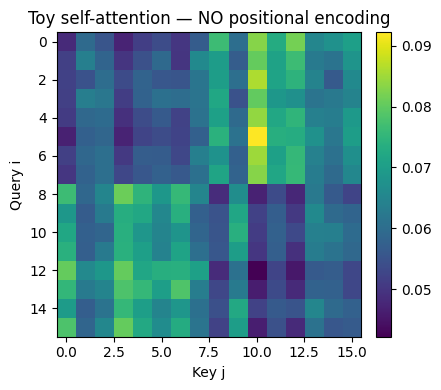

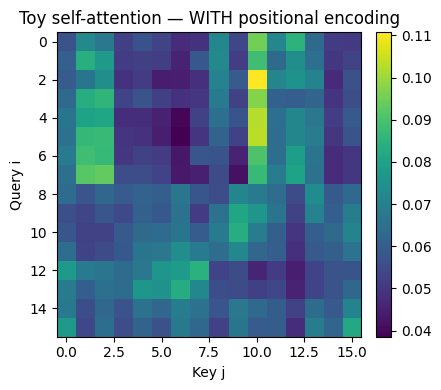

NO PE: blocky pattern driven by content similarity — the two halves attend within their cluster.
WITH PE: diagonal/banded structure appears (neighbors attend more) even with random weights.

Shuffle experiment

NO PE: If you shuffle token order, the attention heatmap looks similar (up to row/column permutation).
WITH PE: If you shuffle token order, the attention heatmap changes significantly.
→ Takeaway: positional encoding injects position information into attention.


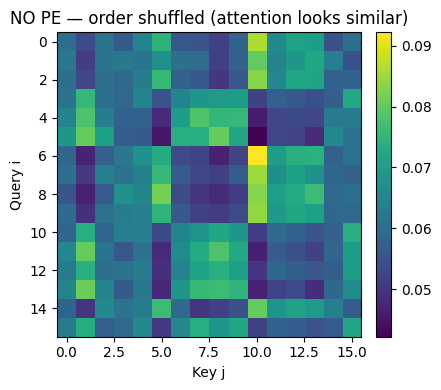

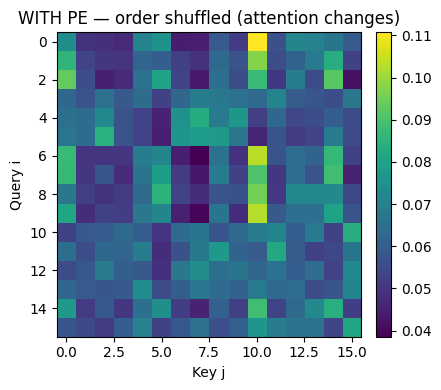

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image  # (kept: not used directly but harmless if you plan to extend)
# torchvision / torchvision.transforms / torch.nn.functional were unused; you can re-add if needed
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from typing import Optional, Tuple


def set_seed(seed: int = 0) -> None:
    """Set numpy/torch seeds for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)


set_seed(0)


# ---------- Utilities: visualization ----------

def show_heatmap(mat, title: str = "", xlabel: str = "", ylabel: str = "", cmap: str = "viridis"):
    """Render a heatmap with a colorbar."""
    plt.figure(figsize=(4.6, 4))
    plt.imshow(mat, cmap=cmap)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def show_patch_attn(attn: np.ndarray, H: int, W: int, title: str = ""):
    """
    Visualize patch attention arranged on an HxW grid.
    attn: 1D array of length H*W with attention weights.
    """
    attn_grid = attn.reshape(H, W)
    plt.figure(figsize=(4.6, 4))
    plt.imshow(attn_grid)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# ---------- Positional encodings ----------

def sinusoid_pe_1d(N: int, C: int) -> torch.Tensor:
    """
    Standard 1D sinusoidal positional encoding (Vaswani et al.).
    Args:
        N: number of positions
        C: channel dimension (must be even)
    Returns:
        [N, C] tensor with sin/cos features.
    """
    assert C % 2 == 0, "C must be even for 1D sin/cos positional encoding."
    position = torch.arange(N, dtype=torch.float32).unsqueeze(1)  # [N, 1]
    div_term = torch.exp(torch.arange(0, C, 2, dtype=torch.float32) * (-math.log(10000.0) / C))
    pe = torch.zeros(N, C, dtype=torch.float32)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


def sinusoid_pe_2d(H: int, W: int, C: int) -> torch.Tensor:
    """
    ViT-style 2D sin/cos positional encoding.
    We split C into two halves (height and width), each using a 1D PE of size C/2,
    then concatenate along channels.

    Args:
        H, W: grid size
        C: total channel dimension (must be divisible by 4 for sin/cos pairs per axis)
    Returns:
        [H*W, C] tensor.
    """
    assert C % 4 == 0, "C must be divisible by 4 for 2D sin/cos PE."
    c = C // 2
    pe_h = sinusoid_pe_1d(H, c)  # [H, c]
    pe_w = sinusoid_pe_1d(W, c)  # [W, c]

    # Vectorized combine (avoid Python loops)
    pe_h_grid = pe_h[:, None, :]        # [H, 1, c]
    pe_w_grid = pe_w[None, :, :]        # [1, W, c]
    pe_grid = torch.cat([pe_h_grid.expand(H, W, c),
                         pe_w_grid.expand(H, W, c)], dim=-1)  # [H, W, 2c] = [H, W, C]
    return pe_grid.reshape(H * W, C)  # [N, C]


# ---------- Single-head self-attention ----------

class SelfAttention(nn.Module):
    """
    Simple single-head self-attention layer.
    Input/Output shapes:
        x: [B, N, C]
        returns: [B, N, C] (and optionally attention matrix [B, N, N])
    """
    def __init__(self, dim: int, d_head: int = 64):
        super().__init__()
        self.q = nn.Linear(dim, d_head)
        self.k = nn.Linear(dim, d_head)
        self.v = nn.Linear(dim, d_head)
        self.out = nn.Linear(d_head, dim)
        self.scale = d_head ** -0.5

    def forward(self, x: torch.Tensor, return_attn: bool = False):
        # x: [B, N, C]
        Q = self.q(x)                   # [B, N, d]
        K = self.k(x)                   # [B, N, d]
        V = self.v(x)                   # [B, N, d]
        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) * self.scale  # [B, N, N]
        attn = attn_scores.softmax(dim=-1)
        y = torch.matmul(attn, V)       # [B, N, d]
        y = self.out(y)                 # [B, N, C]
        if return_attn:
            return y, attn
        return y


# ---------------------------------------------------
# PART 1 — TOY TOKENS (1D sequence) with/without positional encoding
# ---------------------------------------------------

# Build a 1D sequence of N tokens with two content clusters
N, C = 16, 32
x_content = torch.randn(N, C) * 0.3
# Create two groups by shifting means: first half around +1, second half around -1
x_content[: N // 2] += 1.0
x_content[N // 2:] -= 1.0

# Without positional encoding
x_nope = x_content.clone()
# With absolute positional encoding (1D)
x_pe = x_content + sinusoid_pe_1d(N, C)

sa = SelfAttention(dim=C, d_head=32)
sa.eval()
with torch.no_grad():
    y_nope, attn_nope = sa(x_nope.unsqueeze(0), return_attn=True)  # [1, N, C], [1, N, N]
    y_pe, attn_pe = sa(x_pe.unsqueeze(0), return_attn=True)

print("N×N attention maps: row = query i, column = key j.")
print("Value indicates how much token i attends to token j.")

# Visualize attention matrices
show_heatmap(attn_nope.squeeze(0).numpy(),
             title="Toy self-attention — NO positional encoding",
             xlabel="Key j", ylabel="Query i")
show_heatmap(attn_pe.squeeze(0).numpy(),
             title="Toy self-attention — WITH positional encoding",
             xlabel="Key j", ylabel="Query i")

print("NO PE: blocky pattern driven by content similarity — the two halves attend within their cluster.")
print("WITH PE: diagonal/banded structure appears (neighbors attend more) even with random weights.")

print("\nShuffle experiment\n")
print("NO PE: If you shuffle token order, the attention heatmap looks similar (up to row/column permutation).")
print("WITH PE: If you shuffle token order, the attention heatmap changes significantly.")
print("→ Takeaway: positional encoding injects position information into attention.")

# Shuffle experiment: permute token order and recompute
perm = torch.randperm(N)
x_nope_perm = x_nope[perm]
x_pe_perm = x_pe[perm]
with torch.no_grad():
    _, attn_nope_perm = sa(x_nope_perm.unsqueeze(0), return_attn=True)
    _, attn_pe_perm = sa(x_pe_perm.unsqueeze(0), return_attn=True)

show_heatmap(attn_nope_perm.squeeze(0).numpy(),
             title="NO PE — order shuffled (attention looks similar)",
             xlabel="Key j", ylabel="Query i")
show_heatmap(attn_pe_perm.squeeze(0).numpy(),
             title="WITH PE — order shuffled (attention changes)",
             xlabel="Key j", ylabel="Query i")


In [17]:
# ----------------------------
# Full imports (put at top)
# ----------------------------
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Callable


def show_image_with_grid(
    img_tensor: torch.Tensor,
    patch_size: int,
    highlight_hw: Optional[Tuple[int, int]] = None,
    title: str = "",
    fig_size: Tuple[float, float] = (4.6, 4.0),
    line_width: float = 0.5,
    highlight_width: float = 2.0,
) -> None:
    """
    Show a CHW image tensor with an overlaid patch grid. Optionally highlight one patch.

    Args:
        img_tensor: [C, H, W] tensor (values already in displayable range).
        patch_size: grid step (P).
        highlight_hw: optional (h, w) patch to highlight (grid coords).
        title: plot title.
        fig_size: matplotlib figure size.
        line_width: grid line width.
        highlight_width: rectangle edge width for the highlighted patch.
    """
    img_np = img_tensor.detach().cpu().permute(1, 2, 0).numpy()  # [H, W, C]
    H_img, W_img = img_np.shape[:2]

    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(img_np)

    # grid
    for y in range(0, H_img + 1, patch_size):
        ax.axhline(y, linewidth=line_width)
    for x in range(0, W_img + 1, patch_size):
        ax.axvline(x, linewidth=line_width)

    # highlight
    if highlight_hw is not None:
        ph, pw = int(highlight_hw[0]), int(highlight_hw[1])
        rect = plt.Rectangle(
            (pw * patch_size, ph * patch_size),
            patch_size, patch_size,
            fill=False, linewidth=highlight_width
        )
        ax.add_patch(rect)

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


def build_X_cls_batch(
    img_batch: torch.Tensor,
    patch_size: int,
    H_grid: int,
    W_grid: int,
    W_embed_tr: torch.Tensor,   # [3*P*P, C_embed]
    C_embed: int,
) -> torch.Tensor:
    """
    Convert a batch of images into patch embeddings and prepend a CLS token.

    Args:
        img_batch: [B, 3, H, W] (H and W divisible by patch_size).
        patch_size: P.
        H_grid, W_grid: number of patches along H/W.
        W_embed_tr: projection matrix [D, C_embed] with D = 3*P*P (must be on the same device as img_batch).
        C_embed: embedding dim.

    Returns:
        X_cls: [B, N+1, C_embed] with CLS at index 0, N = H_grid * W_grid.
    """
    B = img_batch.shape[0]

    # Extract non-overlapping patches -> [B, 3, H_g, W_g, P, P]
    patches = img_batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    # -> [B, H_g, W_g, 3, P, P]
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    # -> [B, N, D]  with D = 3*P*P
    patches = patches.view(B, H_grid * W_grid, 3 * patch_size * patch_size)

    # Safety checks
    assert W_embed_tr.shape[0] == 3 * patch_size * patch_size, \
        f"W_embed_tr has wrong D: {W_embed_tr.shape[0]} != {3*patch_size*patch_size}"
    assert W_embed_tr.shape[1] == C_embed, \
        f"W_embed_tr has wrong C: {W_embed_tr.shape[1]} != {C_embed}"

    # Ensure device match
    if W_embed_tr.device != img_batch.device:
        W_embed_tr = W_embed_tr.to(img_batch.device)

    # Linear projection: [B, N, D] x [D, C] -> [B, N, C]
    X = torch.einsum("bnd,dc->bnc", patches, W_embed_tr)

    # CLS token (zeros here; you can pass a learnable vector instead if you prefer)
    cls = torch.zeros(B, 1, C_embed, device=X.device)
    X_cls = torch.cat([cls, X], dim=1)  # [B, N+1, C]
    return X_cls


def neighbor_mask(H: int, W: int, h: int, w: int) -> np.ndarray:
    """
    8-neighborhood (Moore) around (h, w), excluding the center. Returns [H, W] float32.
    """
    m = np.zeros((H, W), dtype=np.float32)
    for dh in [-1, 0, 1]:
        for dw in [-1, 0, 1]:
            if dh == 0 and dw == 0:
                continue
            nh, nw = h + dh, w + dw
            if 0 <= nh < H and 0 <= nw < W:
                m[nh, nw] = 1.0
    return m


def neighbor_and_far_masks(
    H: int, W: int, h: int, w: int, radius: int = 1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build two masks on an H×W grid:
      - near: positions within Chebyshev radius (excluding center)
      - far: complement of near, with center set to 0
    """
    near = np.zeros((H, W), dtype=np.float32)
    for dh in range(-radius, radius + 1):
        for dw in range(-radius, radius + 1):
            nh, nw = h + dh, w + dw
            if 0 <= nh < H and 0 <= nw < W and not (dh == 0 and dw == 0):
                near[nh, nw] = 1.0

    far = np.ones((H, W), dtype=np.float32) - near
    far[h, w] = 0.0
    return near, far


def masked_means(
    vec: np.ndarray,
    H_grid: int,
    W_grid: int,
    mask_near: np.ndarray,
    mask_far: np.ndarray
) -> Tuple[float, float]:
    """
    Mean of 'vec' over the provided near/far masks.

    Args:
        vec: flattened attention weights of length H_grid * W_grid.
        H_grid, W_grid: grid shape to reshape 'vec'.
        mask_near, mask_far: [H_grid, W_grid] float arrays with 0/1 entries.

    Returns:
        (near_mean, far_mean).
    """
    grid = vec.reshape(H_grid, W_grid)
    near_sum = (grid * mask_near).sum()
    far_sum = (grid * mask_far).sum()
    near = float(near_sum / max(mask_near.sum(), 1.0))
    far = float(far_sum / max(mask_far.sum(), 1.0))
    return near, far


class TinyViTHead(nn.Module):
    """
    Same as above, but adds optional positional encodings.
    Pass pe2d_full of shape [N+1, C] (row 0 is CLS PE, e.g., zeros).
    """
    def __init__(
        self,
        embed_dim: int,
        num_classes: int = 10,
        use_pe: bool = True,
        global_token: str = "cls",
        pe2d_full: Optional[torch.Tensor] = None,  # [N+1, C]
        d_head: int = 32,
    ):
        super().__init__()
        self.global_token = global_token.lower()
        self.use_pe = use_pe
        d_head = min(d_head, embed_dim)

        # single-head attention
        self.q = nn.Linear(embed_dim, d_head)
        self.k = nn.Linear(embed_dim, d_head)
        self.v = nn.Linear(embed_dim, d_head)
        self.proj = nn.Linear(d_head, embed_dim)
        self.scale = d_head ** -0.5

        # classifier
        self.cls_head = nn.Linear(embed_dim, num_classes)

        # store PE (can be None if use_pe=False)
        if use_pe:
            assert pe2d_full is not None, "Provide pe2d_full=[N+1,C] when use_pe=True."
            self.register_buffer("pe2d_full", pe2d_full)
        else:
            self.register_buffer("pe2d_full", torch.zeros(1, embed_dim))

    def forward(self, X_cls: torch.Tensor):
        """
        X_cls: [B, N+1, C]
        Returns: logits [B, num_classes], attention [B, N+1, N+1]
        """
        if self.use_pe:
            X_in = X_cls + self.pe2d_full.to(X_cls.device).unsqueeze(0)
        else:
            X_in = X_cls

        Q = self.q(X_in)
        K = self.k(X_in)
        V = self.v(X_in)

        A = (Q @ K.transpose(-1, -2)) * self.scale
        A = A.softmax(dim=-1)

        Y = self.proj(A @ V)  # [B, N+1, C]

        if self.global_token == "cls":
            g = Y[:,0, :]
        else:
            g = Y[:, 1:, :].mean(dim=1)

        logits = self.cls_head(g)
        return logits, A

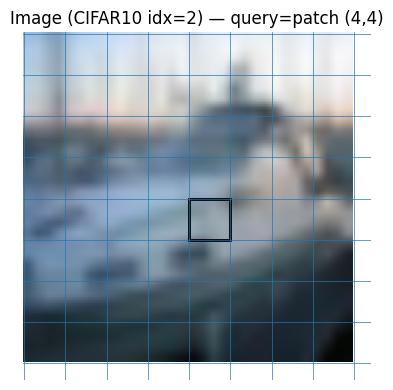

[Check 2] Shapes: N_patches=64, grid=8x8, attn=[65, 65]

[Part 2] Image patches & 2D PE — Reading guide:
- Visualize with patch grid; choose query (CLS or a patch).
- Compare attention maps with and without 2D PE.
- Expectation: WITHOUT PE, attention ignores layout; WITH PE, neighborhood patterns emerge.



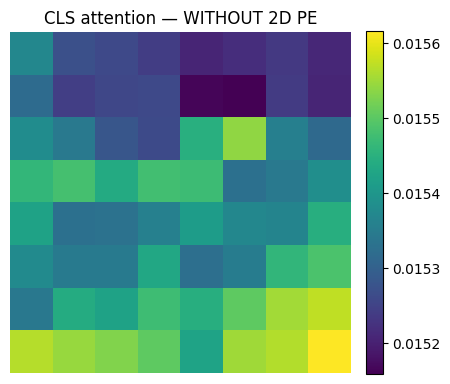

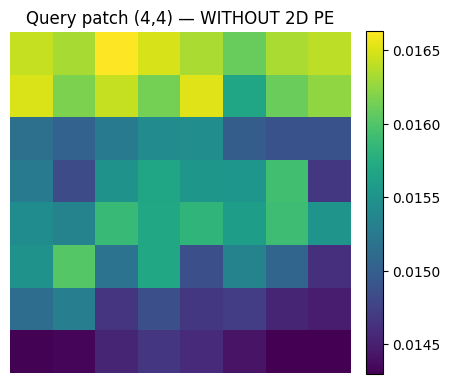


Starting tiny supervised training (CLS head)
Goal: make attention maps less random and more image-coherent.
We will use a small CIFAR10 subset, a few iterations, then visualize attentions on the same image.

[Train] step=200  loss=2.0067
[Train] step=400  loss=1.9121

[Note] This training is intentionally short: we are not chasing best accuracy,
but injecting a supervised signal that makes attention more interpretable.


[Result] Post-training prediction:
- Predicted class: ship  (confidence ≈ 0.38)



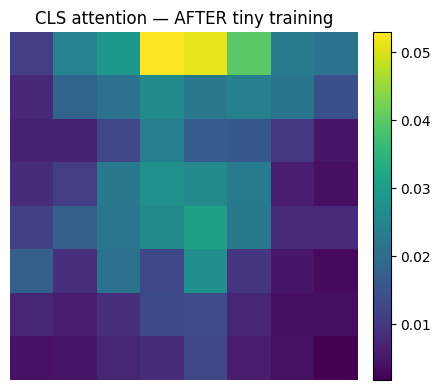

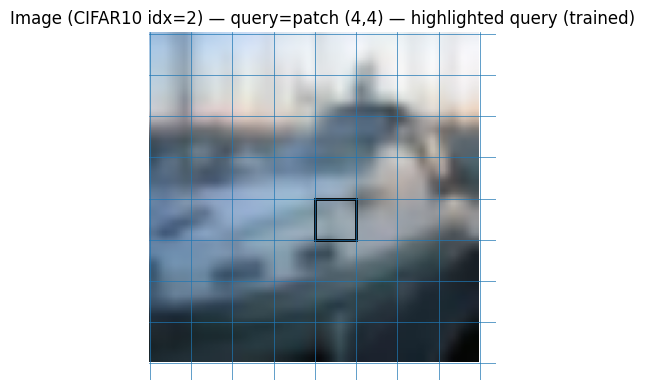

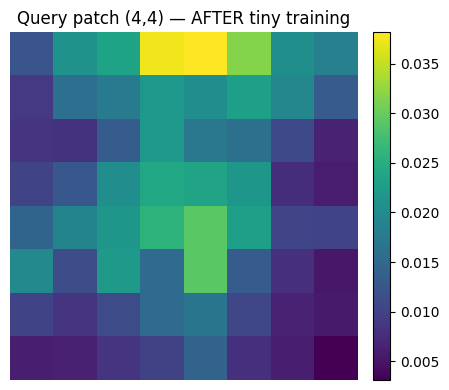


Conclusions PART 3:
- A small amount of supervision structures attention and improves map readability.
- The benefit is visible even with few iterations and a tiny model.
- For further improvements: more steps, relative PE, or a wider multi-head attention.


[Patch-query metrics — summary]
Mean weights NEAR / FAR (patch 4,4):
- NO PE   → near=0.0153 | far=0.0155
- AFTER   → near=0.0169 | far=0.0144



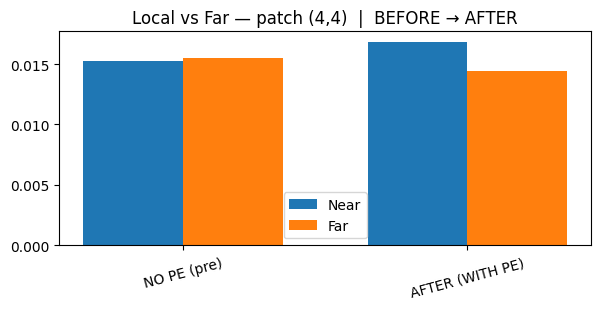


Done. Key observations:
- Without PE, attention does not "feel" position.
- With 2D PE, locality/layout appears, visible from both CLS and patch queries.



In [18]:
# ---------------------------------------------------
# PART 2 — IMAGE PATCHES (ViT-style) with 2D positional encoding
# (Configurable image & query, explicit visualization, and sanity checks)
# ---------------------------------------------------


# ==== CONFIG (easy to tweak) ====
CFG = {
    "dataset_index": 2,
    "resize_hw": (128, 128),
    "patch_size": 16,
    "embed_dim": 32,
    "query_mode": "patch",      # "cls" or "patch"
    "query_patch_hw": None,     # (h, w) or None -> center
    "global_token": "cls"       # "cls" or "pooled"
}

# ==== CONFIG (training) ====
TRN = {
    "subset_size": 6024,
    "batch_size": 256,
    "epochs": 20,
    "lr": 3e-3,
    "weight_decay": 1e-4,
    "use_pe": True,
    "amp": False
}

# ==== IMAGE LOADING & VISUALIZATION ====
transform = T.Compose([
    T.Resize(CFG["resize_hw"]),
    T.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
img_pil, label = dataset[CFG["dataset_index"]]
img = transform(img_pil)  # [3, H_img, W_img]

# ---- Patchify config
P = CFG["patch_size"]
H_grid = CFG["resize_hw"][0] // P
W_grid = CFG["resize_hw"][1] // P
assert CFG["resize_hw"][0] % P == 0 and CFG["resize_hw"][1] % P == 0, "resize_hw must be divisible by patch_size"

# ---- Decide query patch (if needed)
if CFG["query_mode"].lower() == "patch":
    if CFG["query_patch_hw"] is None:
        q_h, q_w = H_grid // 2, W_grid // 2
    else:
        q_h, q_w = CFG["query_patch_hw"]
    q_h = int(max(0, min(H_grid - 1, q_h)))
    q_w = int(max(0, min(W_grid - 1, q_w)))
else:
    q_h = q_w = None  # not used for CLS

# ---- Show the image and grid
_show_title = (
    f"Image (CIFAR10 idx={CFG['dataset_index']}) — query={'CLS' if CFG['query_mode']=='cls' else f'patch ({q_h},{q_w})'}"
)
show_image_with_grid(img, patch_size=P, highlight_hw=None if CFG["query_mode"] == "cls" else (q_h, q_w), title=_show_title)

# ==== PATCH EMBEDDINGS (Part 2, pre-training demo) ====
C_embed = CFG["embed_dim"]

# Extract patches: [N, 3*P*P]
patches = img.unfold(1, P, P).unfold(2, P, P)           # [3, H_grid, W_grid, P, P]
patches = patches.permute(1, 2, 0, 3, 4).contiguous()    # [H_grid, W_grid, 3, P, P]
patches = patches.view(H_grid * W_grid, 3 * P * P)       # [N, D]
N = H_grid * W_grid

# Simple linear patch embedding (CPU ok for Part 2)
W_embed = torch.randn(3 * P * P, C_embed) * 0.05
X = patches @ W_embed                                    # [N, C_embed]

# Add a CLS token (index 0)
cls = torch.zeros(1, C_embed)
X_cls = torch.cat([cls, X], dim=0)                       # [N+1, C]

# Build 2D PE for patches (+ a zero PE for CLS) -- this is the pe2d_full you'll use in training too
PE2d = sinusoid_pe_2d(H_grid, W_grid, C_embed)           # [N, C]
pe2d_full_cpu = torch.cat([torch.zeros(1, C_embed), PE2d], dim=0)  # [N+1, C]

X_nope = X_cls.clone()
X_pe   = X_cls + pe2d_full_cpu

# Minimal attention for the Part-2 demo (separate from the trainable model)
class _SA(nn.Module):
    def __init__(self, dim, d_head=32):
        super().__init__()
        d_head = min(d_head, dim)
        self.q = nn.Linear(dim, d_head)
        self.k = nn.Linear(dim, d_head)
        self.v = nn.Linear(dim, d_head)
        self.out = nn.Linear(d_head, dim)
        self.scale = d_head ** -0.5
    def forward(self, x, return_attn=False):
        Q = self.q(x); K = self.k(x); V = self.v(x)
        A = (Q @ K.transpose(-1, -2)) * self.scale
        A = A.softmax(dim=-1)
        y = self.out(A @ V)
        return (y, A) if return_attn else y

sa_img = _SA(dim=C_embed, d_head=32)
sa_img.eval()
with torch.no_grad():
    attn_nope = sa_img(X_nope.unsqueeze(0), return_attn=True)[1].squeeze(0)  # [N+1, N+1]
    attn_pe   = sa_img(X_pe.unsqueeze(0),   return_attn=True)[1].squeeze(0)

print(f"[Check 2] Shapes: N_patches={N}, grid={H_grid}x{W_grid}, attn={list(attn_nope.shape)}")

print("""
[Part 2] Image patches & 2D PE — Reading guide:
- Visualize with patch grid; choose query (CLS or a patch).
- Compare attention maps with and without 2D PE.
- Expectation: WITHOUT PE, attention ignores layout; WITH PE, neighborhood patterns emerge.
""")

# ---- Visualize CLS attention
attn_cls_nope = attn_nope[0, 1:].detach().cpu().numpy()
attn_cls_pe   = attn_pe[0, 1:].detach().cpu().numpy()
if CFG["global_token"].lower() == "cls":
    show_patch_attn(attn_cls_nope, H_grid, W_grid, title="CLS attention — WITHOUT 2D PE")
else:
    print("[Note] global_token='pooled': skipping CLS map.")

# ---- Visualize patch query
if CFG["query_mode"].lower() == "patch":
    q_idx = 1 + (q_h * W_grid + q_w)
    attn_q_nope = attn_nope[q_idx, 1:].detach().cpu().numpy()
    attn_q_pe   = attn_pe[q_idx, 1:].detach().cpu().numpy()
    show_patch_attn(attn_q_nope, H_grid, W_grid, title=f"Query patch ({q_h},{q_w}) — WITHOUT 2D PE")
else:
    print("[Note] query_mode='cls': skipping Patch→All visualization.")


# ---------------------------------------------------
# PART 3 — LIGHT TRAINING to make attentions more meaningful
# ---------------------------------------------------

# Train transforms
train_tf = T.Compose([
    T.Resize(CFG["resize_hw"]),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tf)
indices = torch.randperm(len(cifar_train))[:TRN["subset_size"]].tolist()
subset = torch.utils.data.Subset(cifar_train, indices)
loader = torch.utils.data.DataLoader(subset, batch_size=TRN["batch_size"], shuffle=True, num_workers=2, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Patch embedding matrix for training — create ON DEVICE
W_embed_tr = torch.randn(3 * P * P, C_embed, device=device) * 0.05

# Build pe2d_full for the model and move it to device  <<-- this is the change you asked for
pe2d_full = pe2d_full_cpu.to(device) if TRN["use_pe"] else torch.zeros(1, C_embed, device=device)

# Build model (simple TinyViTHead with pe2d_full)
model = TinyViTHead(
    embed_dim=C_embed,
    num_classes=10,
    use_pe=TRN["use_pe"],
    global_token=CFG["global_token"],
    pe2d_full=pe2d_full,         # <<-- pass the ready tensor
    d_head=32,
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=TRN["lr"], weight_decay=TRN["weight_decay"])
scaler = torch.amp.GradScaler('cuda', enabled=(TRN["amp"] and device.type == 'cuda'))
criterion = nn.CrossEntropyLoss()

print("""
Starting tiny supervised training (CLS head)
Goal: make attention maps less random and more image-coherent.
We will use a small CIFAR10 subset, a few iterations, then visualize attentions on the same image.
""")

model.train()
steps = 0
for epoch in range(TRN["epochs"]):
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # tokens batch (no globals)
        X_cls_b = build_X_cls_batch(
            img_batch=imgs,
            patch_size=P,
            H_grid=H_grid,
            W_grid=W_grid,
            W_embed_tr=W_embed_tr,
            C_embed=C_embed,
        )  # [B, N+1, C]

        with torch.amp.autocast('cuda', enabled=(TRN["amp"] and device.type == 'cuda')):
            logits, _ = model(X_cls_b)
            loss = criterion(logits, labels)

        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        steps += 1
        if steps % 200 == 0:
            print(f"[Train] step={steps}  loss={loss.item():.4f}")

print("""
[Note] This training is intentionally short: we are not chasing best accuracy,
but injecting a supervised signal that makes attention more interpretable.
""")

# ---- Evaluate on the same Part-2 image
model.eval()
with torch.no_grad():
    X_single = build_X_cls_batch(
        img_batch=img.unsqueeze(0).to(device),
        patch_size=P,
        H_grid=H_grid,
        W_grid=W_grid,
        W_embed_tr=W_embed_tr,
        C_embed=C_embed,
    )  # [1, N+1, C]
    logits, A = model(X_single)                                # [1, 10], [1, N+1, N+1]
    A = A.squeeze(0).cpu()
    A_post = A
    probs = F.softmax(logits, dim=-1).squeeze(0).cpu().numpy()

# Show predicted class and confidence
classes = cifar_train.classes
pred_idx = int(np.argmax(probs))
print(f"""
[Result] Post-training prediction:
- Predicted class: {classes[pred_idx]}  (confidence ≈ {probs[pred_idx]:.2f})
""")

# ---- Visualize CLS and patch-query attentions after training
if CFG["global_token"].lower() == "cls":
    attn_cls_trained = A[0, 1:].numpy()
    show_patch_attn(attn_cls_trained, H_grid, W_grid, title="CLS attention — AFTER tiny training")
else:
    print("[Note] global_token='pooled': no CLS map after training.")

if CFG["query_mode"].lower() == "patch":
    q_idx = 1 + (q_h * W_grid + q_w)
    attn_q_trained = A[q_idx, 1:].numpy()
    show_image_with_grid(img, patch_size=P, highlight_hw=(q_h, q_w), title=_show_title + " — highlighted query (trained)")
    show_patch_attn(attn_q_trained, H_grid, W_grid, title=f"Query patch ({q_h},{q_w}) — AFTER tiny training")
else:
    print("[Note] query_mode!='patch': skipping patch-query map after training.")

print("""
Conclusions PART 3:
- A small amount of supervision structures attention and improves map readability.
- The benefit is visible even with few iterations and a tiny model.
- For further improvements: more steps, relative PE, or a wider multi-head attention.
""")

# ==== EXTRA: Quantify Local vs Far (with bar chart) ====
try:
    if CFG["query_mode"].lower() == "patch":
        q_idx = 1 + (q_h * W_grid + q_w)
        attn_q_nope_pre = attn_nope[q_idx, 1:].detach().cpu().numpy()
        attn_q_after    = A_post[q_idx, 1:].detach().cpu().numpy()

        M_near, M_far = neighbor_and_far_masks(H_grid, W_grid, q_h, q_w, radius=2)
        near_nope,  far_nope  = masked_means(attn_q_nope_pre, H_grid, W_grid, M_near, M_far)
        near_after, far_after = masked_means(attn_q_after,    H_grid, W_grid, M_near, M_far)

        print(f"""
[Patch-query metrics — summary]
Mean weights NEAR / FAR (patch {q_h},{q_w}):
- NO PE   → near={near_nope:.4f} | far={far_nope:.4f}
- AFTER   → near={near_after:.4f} | far={far_after:.4f}
""")
        labels = ["NO PE (pre)", "AFTER (WITH PE)"]
        near_vals = [near_nope, near_after]
        far_vals  = [far_nope,  far_after]
        x = np.arange(len(labels))
        width = 0.35
        plt.figure(figsize=(6.2, 3.2))
        plt.bar(x - width / 2, near_vals, width, label="Near")
        plt.bar(x + width / 2, far_vals,  width, label="Far")
        plt.xticks(x, labels, rotation=15)
        plt.title(f"Local vs Far — patch ({q_h},{q_w})  |  BEFORE → AFTER")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("[Note] CFG['query_mode']!='patch': 'Near vs Far' metrics are disabled.")
except Exception as e:
    print(f"[Warning] Patch-query metrics not computed: {e}")

print("""
Done. Key observations:
- Without PE, attention does not "feel" position.
- With 2D PE, locality/layout appears, visible from both CLS and patch queries.
""")